# API总体演示

这里将演示：
1. 初始化过程
2. 图像通路和图像处理
3. Arduino microblaze API

颜色检测和HDMI输出在3.color_tracing.ipynb中演示

## 导入库文件并对PL编程

In [1]:
import numpy as np
from PYNQ_Car.CarOverlay.CarOverlay import CarOverlay
from pynq.overlay import Overlay 
from PIL import Image
import IPython
overlay = CarOverlay('/usr/local/lib/python3.6/dist-packages/PYNQ_Car/Overlay/Car.bit')

## 初始化各个模块

### 实例化对象

In [2]:
OV5640 = overlay.OV5640
video_proc = overlay.video_proc
arduino = overlay.Arduino

### 配置外设引脚并初始化Arduino microblaze

![](data/microblaze.jpg)

编码器连接在Arduino模拟口A0~A3，超声波的sig信号连接在数字口D0，其余的可以根据车体配置。

**注意**：模拟口包含下拉电阻而编码器输出一般为OD门，有上拉电阻，所以输入管教的电压会小于5V，请确定这一电压不会超过3.3V，否则可能损坏器件。

左电机连接在0号电机驱动器，右电机连接在1号驱动器。左编码器连接在A0~A1,右编码器连接在A2~A3

In [3]:
arduino.load('bimotor')
arduino.set_iic_pins('SDA','SCL') #SDA  SCL
arduino.set_motor_pins('D11','D5','D6','D3')
arduino.set_motor_mode('full_bridge')
arduino.set_servo_pin('D9')
arduino.init()

### 配置电机和编码器方向

注意，这里要令电机正转时编码器的读数也为正

In [4]:
arduino.set_encoder_dir(1,0)
arduino.set_motor_dir(1,0)

## 图像通路和图像处理模块的使用

### 编写在notebook上显示图像的函数

In [5]:
def imshow_rgba(frame):
    image = Image.fromarray(frame)
    r, g, b, a = image.split()
    image = Image.merge('RGBA', [r,g,b,a])
    IPython.display.clear_output(1)
    display(image)
def imshow_gray(frame):
    image = Image.fromarray(frame)
    gray,_ , _ , _ = image.split()
    image = Image.merge('L', [gray])
    IPython.display.clear_output(1)
    display(image)

### 从OV5640摄像头读入RGBA图，分辨率1280×720

In [6]:
OV5640.set_rgba()

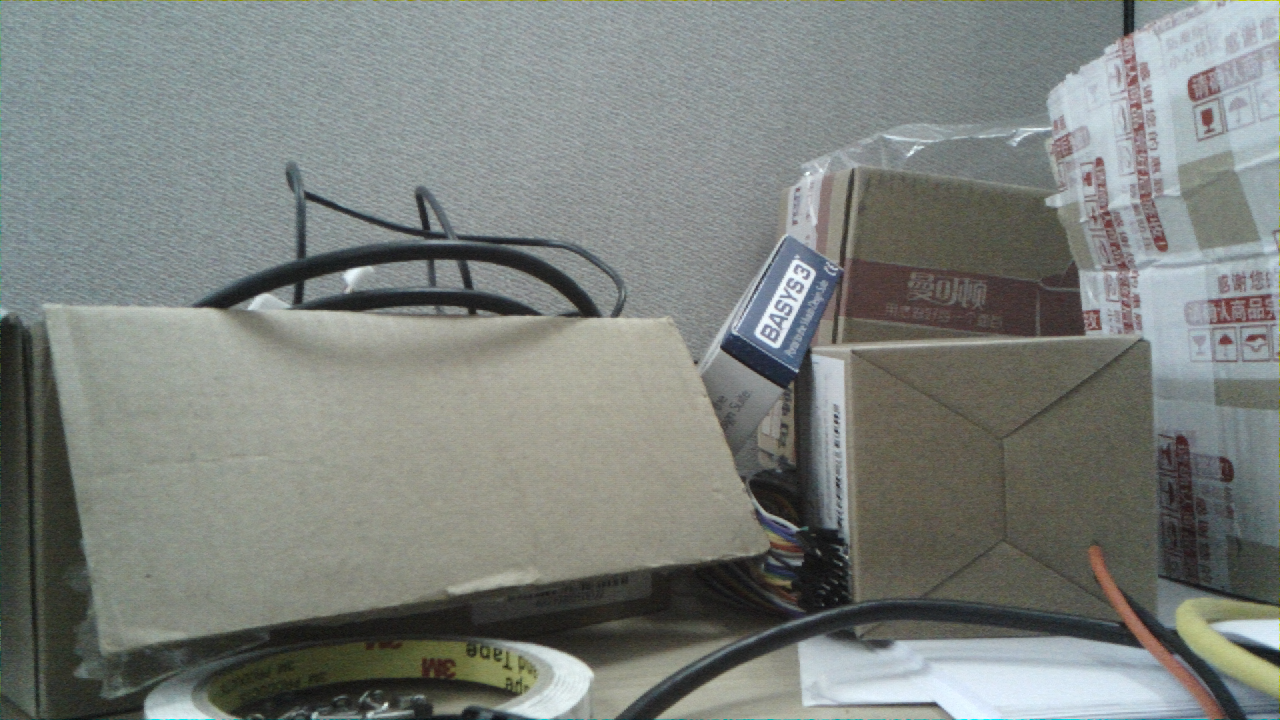

In [7]:
frame = OV5640.get_cam_frame()
imshow_rgba(frame)
frame.freebuffer()

### 从OV5640摄像头读入灰度图，分辨率1280×720

注意，这里图片尺寸仍然是1280×720×4，有效数据在通道0

In [8]:
OV5640.set_gray()

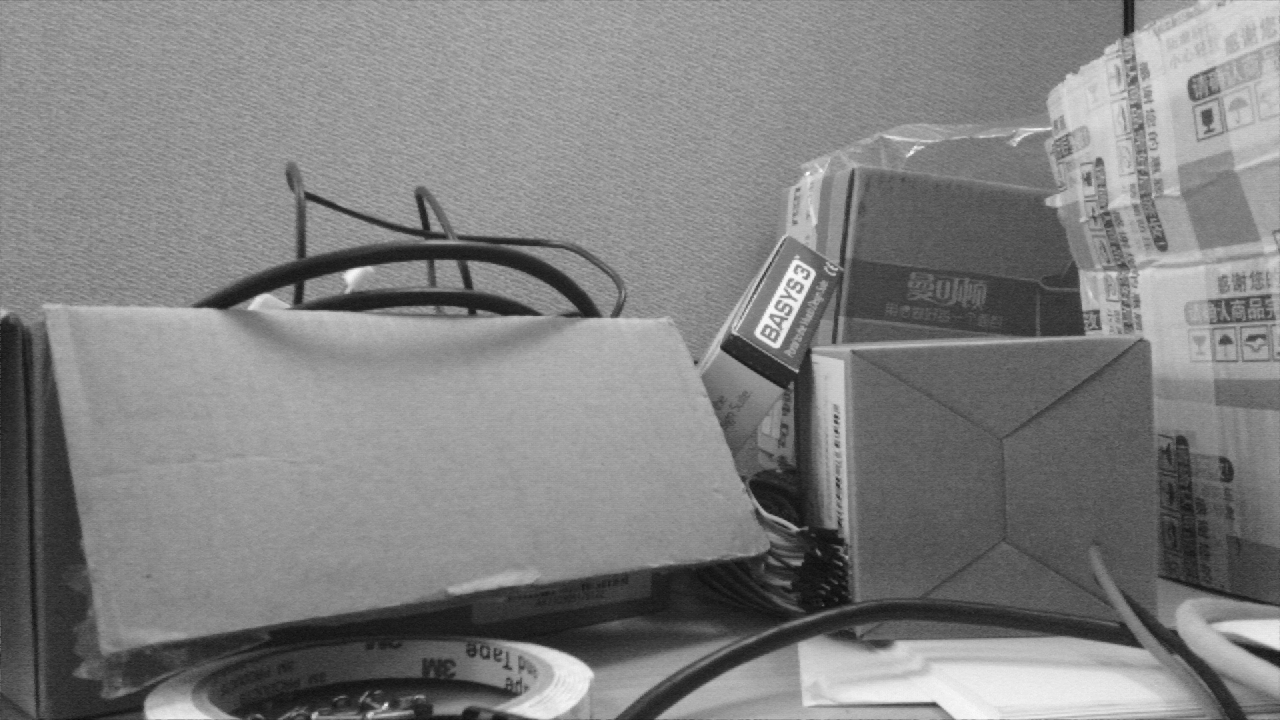

In [9]:
frame = OV5640.get_cam_frame()
imshow_gray(frame)
frame.freebuffer()

### 测试图像处理通路是否正常

注意，这里不对图像做任何处理

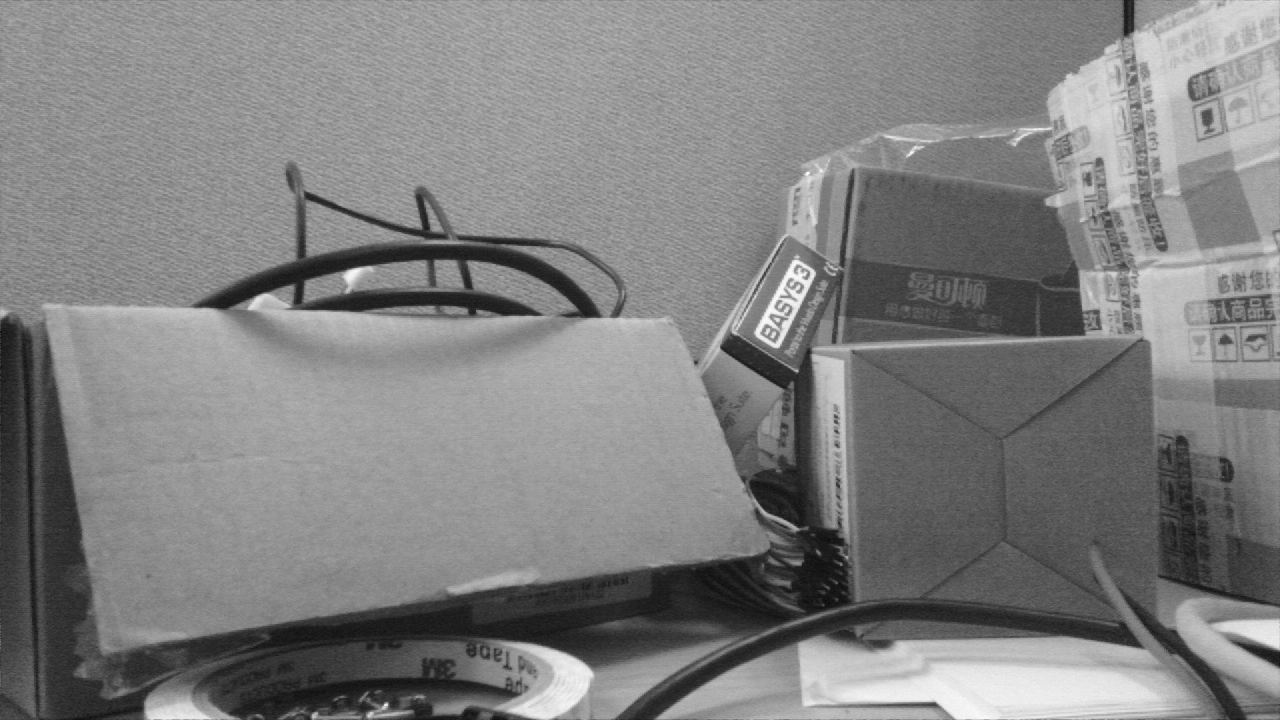

In [10]:
frame = OV5640.get_cam_frame()
res = video_proc.Bypass(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### X方向Sobel滤波

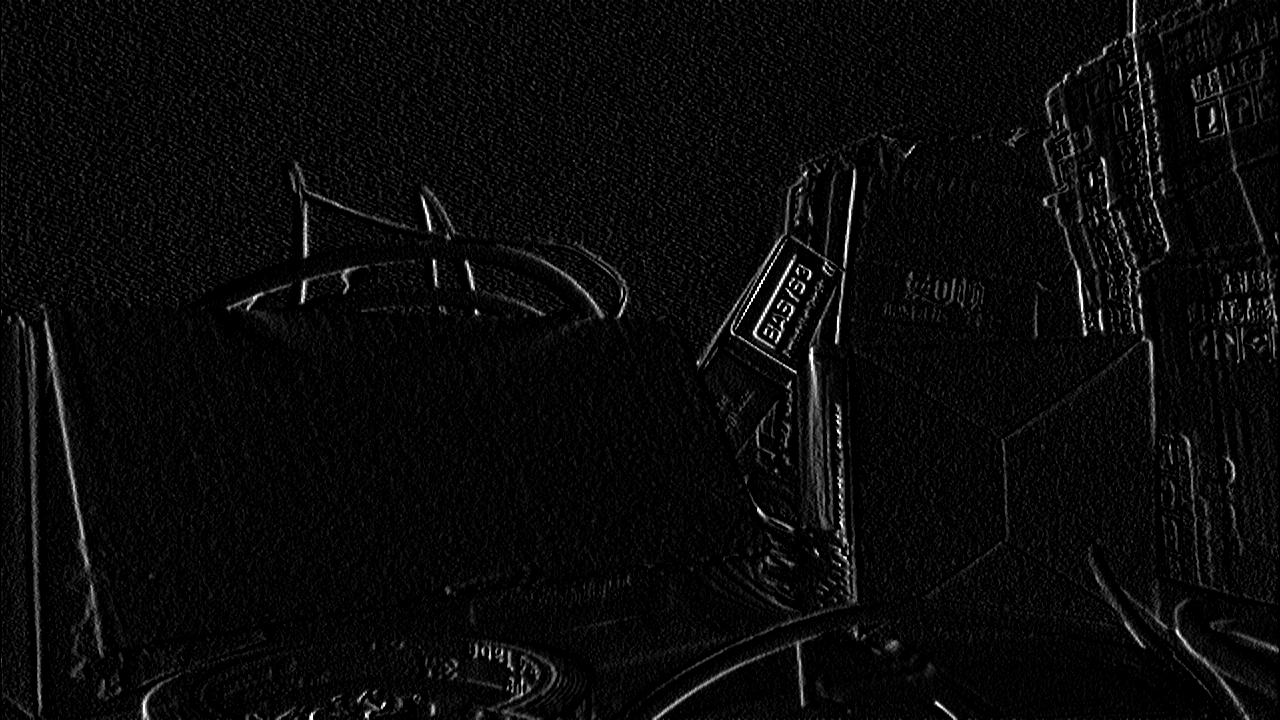

In [11]:
frame = OV5640.get_cam_frame()
res = video_proc.SobelX(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### Y方向Sobel滤波

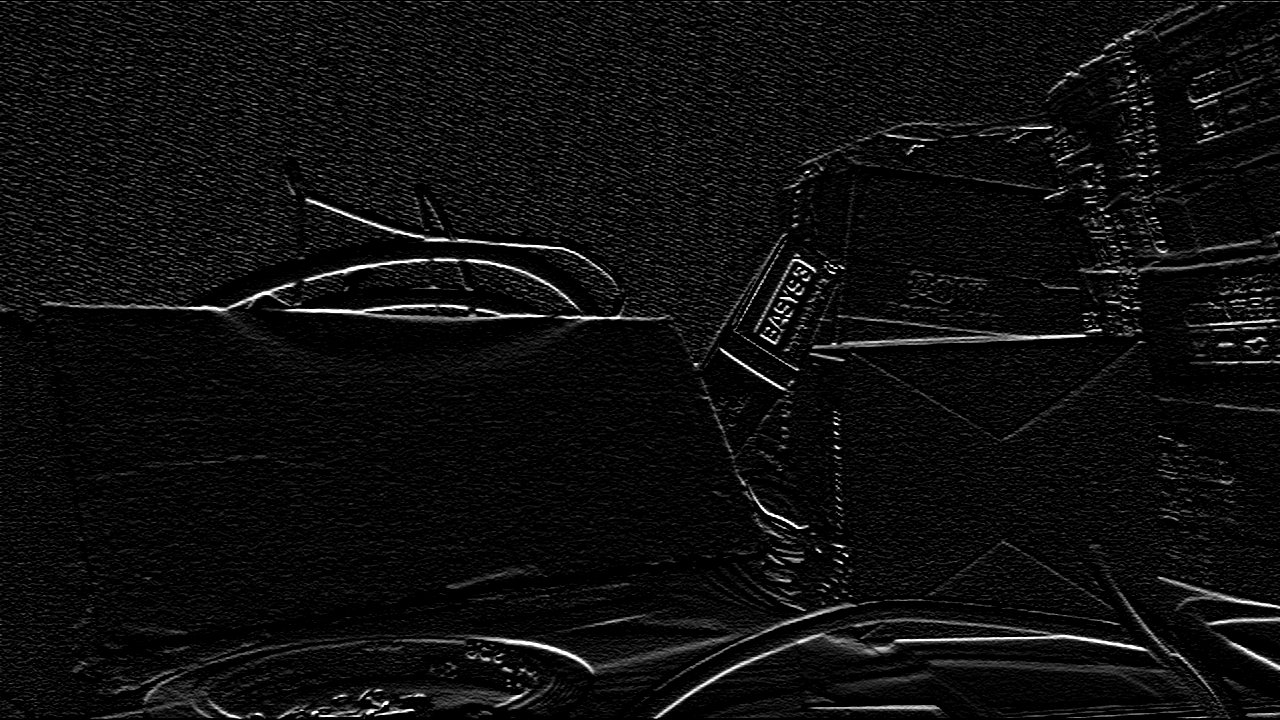

In [12]:
frame = OV5640.get_cam_frame()
res = video_proc.SobelY(frame)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

### Canny算子

强边缘亮度值为255，弱边缘亮度值为127，非边缘亮度值为0

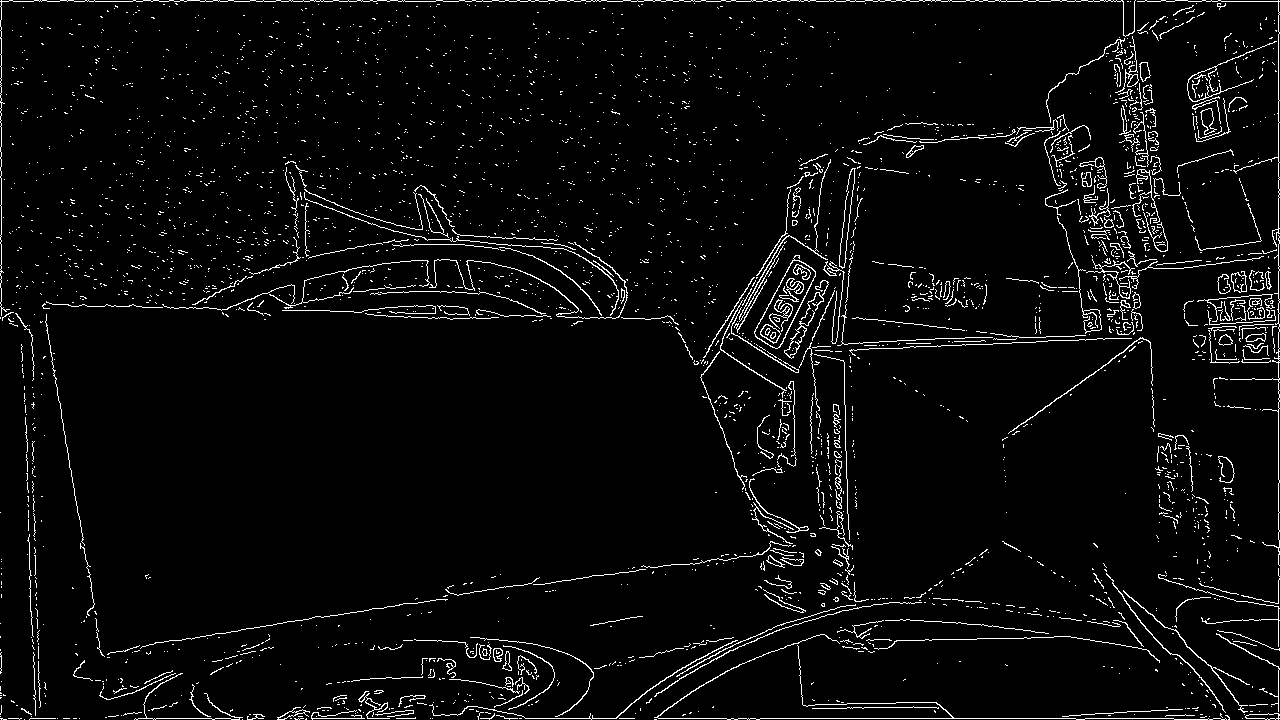

In [13]:
frame = OV5640.get_cam_frame()
res = video_proc.Canny(frame,60,80)
imshow_gray(res)
frame.freebuffer()
res.freebuffer()

## Arduino microblaze API演示

### IMU API演示

In [14]:
%%timeit -n 100
ax,ay,az = arduino.get_accl()

100 loops, best of 3: 1.21 ms per loop


In [15]:
%%timeit -n 100
gx,gy,gz = arduino.get_gyro()

100 loops, best of 3: 1.22 ms per loop


In [16]:
%%timeit -n 100
cx,cy,cz = arduino.get_compass()

100 loops, best of 3: 1.22 ms per loop


### 运动控制API演示

#### 舵机角度控制

In [17]:
arduino.set_servo_angle(-45)

In [18]:
arduino.set_servo_angle(45)

In [19]:
arduino.set_servo_angle(0)

#### 电机速度控制

In [20]:
arduino.set_velocity(500)

In [21]:
arduino.set_velocity(-500)

In [22]:
arduino.set_velocity(0)

#### 编码器数据读取（用于调试）

In [23]:
left,right = arduino.get_encoder_data()
print(left,right)

0 1


#### 超声波测距模块数据读取（单位：cm）

In [24]:
import time
count = 50
while(count > 0):
    print(arduino.get_ultra_cm())
    count = count - 1
    time.sleep(0.3)

109.82758620689656
110.20689655172414
46.0
25.0
24.67241379310345
30.120689655172413
500
18.482758620689655
11.724137931034482
16.56896551724138
24.155172413793103
30.224137931034484
36.56896551724138
42.672413793103445
48.56896551724138
52.96551724137931
55.56896551724138
58.86206896551724
68.27586206896552
72.46551724137932
77.93103448275862
78.10344827586206
79.53448275862068
79.91379310344827
72.12068965517241
57.94827586206897
500
42.3448275862069
36.62068965517241
31.0
26.137931034482758
22.413793103448278
19.189655172413794
15.758620689655173
12.46551724137931
11.482758620689655
15.586206896551724
19.637931034482758
24.56896551724138
28.46551724137931
31.448275862068964
34.96551724137931
38.43103448275862
41.08620689655172
43.96551724137931
46.3448275862069
49.241379310344826
54.60344827586207
61.03448275862069
63.12068965517241


#### 复位

In [25]:
arduino.reset()

## 结束，务必将图像通路关闭

In [26]:
OV5640.stop()
video_proc.stop()